In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import folium
import plotly.express as px

##### Join two datasets and have pickup and drop off details with lat/lon

In [130]:
table1 = pd.read_excel('C:\Projects\VGI Challenge\FLEXI_bus_stops.xls')
table2 = pd.read_excel('C:\Projects\VGI Challenge\FLEXI_trip_data.xls')

merged_data = table2.merge(table1, left_on="Pickup ID", right_on="index", how="left") \
                    .merge(table1, left_on="Dropoff ID", right_on="index", how="left", suffixes=('', '_dropoff')) \
                    .rename(columns={
                        "index": "pickup_index",
                        "name": "pickup_name",
                        "district": "pickup_district",
                        "latitude": "pickup_latitude",
                        "longitude": "pickup_longitude"
                    }) \
                    .drop(columns=["Pickup ID", "Dropoff ID"])


In [131]:
table2.info()
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3838 entries, 0 to 3837
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Booking ID           3838 non-null   int64         
 1   Status               3838 non-null   object        
 2   Passenger status     3838 non-null   object        
 3   Passengers           3838 non-null   int64         
 4   Pickup ID            3838 non-null   int64         
 5   Dropoff ID           3838 non-null   int64         
 6   Actual Pickup Time   3838 non-null   datetime64[ns]
 7   Actual Dropoff Time  3838 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 240.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3838 entries, 0 to 3837
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Booking ID           3838 n

In [118]:
merged_data['Actual Pickup Time'] = pd.to_datetime(merged_data['Actual Pickup Time'])
merged_data['Actual Dropoff Time'] = pd.to_datetime(merged_data['Actual Dropoff Time'])
merged_data['Pickup Hour'] = merged_data['Actual Pickup Time'].dt.hour
merged_data['Pickup Day'] = merged_data['Actual Pickup Time'].dt.dayofweek  # 0 = Monday, 1= Tuesday, 2 = Wednesday ... 

In [119]:
merged_data.head()

,Booking ID,Status,Passenger status,Passengers,Actual Pickup Time,Actual Dropoff Time,pickup_index,pickup_name,pickup_district,pickup_latitude,pickup_longitude,index_dropoff,name_dropoff,district_dropoff,latitude_dropoff,longitude_dropoff,Pickup Hour,Pickup Day
0,252392,Validated,Trip completed,2,2024-09-01 08:01:00,2024-09-01 08:17:00,55.0,"Kottingwoerth, Dietfurter Strasse",Kottingw√∂rth,49.019003,11.520783,NaN,NaN,NaN,NaN,NaN,8,6
1,253212,Cancelled by client,Cancelled,1,2024-09-01 08:18:00,2024-09-01 08:34:00,40.0,"Irfersdorf, Am Kirchplatz",Irfersdorf,48.994215,11.461103,0.0,"Kinding, Bahnhof",Kinding,48.992168,11.377365,8,6
2,253369,Cancelled by client,Cancelled,3,2024-09-01 08:46:00,2024-09-01 09:09:00,66.0,"Wiesenhofen, Kirche",Litterzhofen,49.043035,11.412738,0.0,"Kinding, Bahnhof",Kinding,48.992168,11.377365,8,6
3,253808,Cancelled by driver,Cancelled,2,2024-09-01 08:56:00,2024-09-01 09:09:00,30.0,"Beilngries, Frauenkirche",Beilngries,49.036378,11.470632,0.0,"Kinding, Bahnhof",Kinding,48.992168,11.377365,8,6
4,253782,Validated,Trip completed,2,2024-09-01 09:14:00,2024-09-01 09:25:00,40.0,"Irfersdorf, Am Kirchplatz",Irfersdorf,48.994215,11.461103,21.0,"Beilngries, Deutscher Hof",Beilngries,49.033525,11.475793,9,6


In [120]:
# Group by Pickup Demand
pickup_demand = merged_data.groupby(['pickup_name', 'pickup_latitude', 'pickup_longitude'])['Passengers'].sum().reset_index(name='demand')

# Interactive map heatmap
map_center = [pickup_demand['pickup_latitude'].mean(), pickup_demand['pickup_longitude'].mean()]
map_ = folium.Map(location=map_center, zoom_start=10)
HeatMap(data=pickup_demand[['pickup_latitude', 'pickup_longitude', 'demand']].values, radius=15).add_to(map_)
map_.save("pickup_demand_heatmap.html")

In [121]:
#hourly demand
hourly_demand = merged_data.groupby('Pickup Hour').size().reset_index(name='demand')

hourly_demand

,Pickup Hour,demand
0,5,132
1,6,179
2,7,190
3,8,224
4,9,151
5,10,151
6,11,193
7,12,226
8,13,237
9,14,340


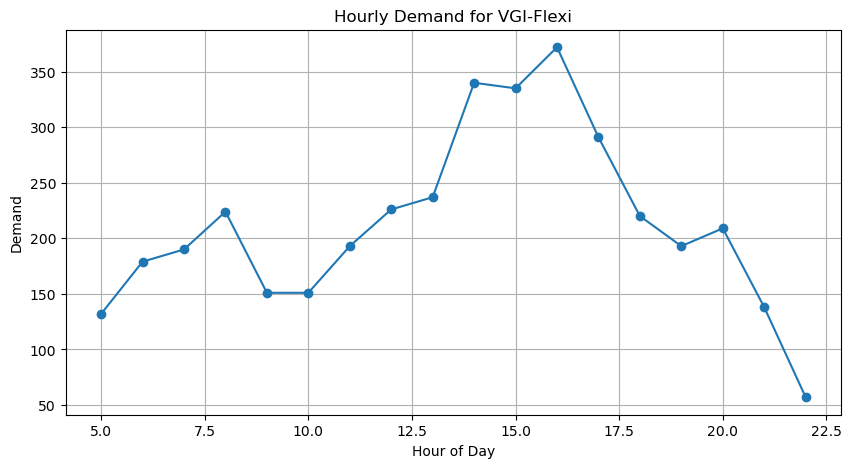

In [123]:
# Line plot for demand over time
plt.figure(figsize=(10, 5))
plt.plot(hourly_demand['Pickup Hour'], hourly_demand['demand'], marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Demand')
plt.title('Hourly Demand for VGI-Flexi')
plt.grid()
plt.show()

In [126]:
fig = px.density_mapbox(
    merged_data,
    lat='pickup_latitude',
    lon='pickup_longitude',
    animation_frame='Pickup Hour',
    radius=15,
    center=dict(lat=map_center[0], lon=map_center[1]),
    zoom=10,
    mapbox_style='carto-positron'
)
fig.show()